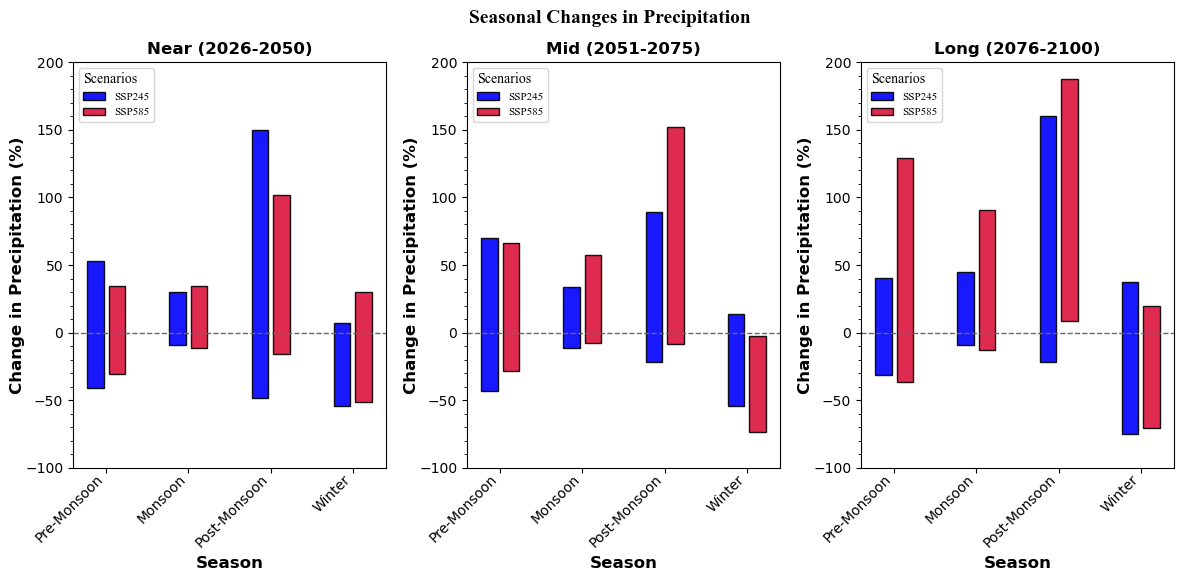

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
import datetime
import calendar

df = pd.read_csv(r"D:\Script\From_RAJ\Code\PrecipData.csv")
df['date'] = pd.to_datetime(df['date'])

df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day

timespan_dict = {'Base': [1990, 2014],
                 'Near': [2026, 2050],
                 'Mid': [2051, 2075],
                 'Long': [2076, 2100]}

ts_conditions = [
                (df['date'].dt.year >= timespan_dict['Base'][0]) & (df['date'].dt.year <= timespan_dict['Base'][1]),
                (df['date'].dt.year >= timespan_dict['Near'][0]) & (df['date'].dt.year <= timespan_dict['Near'][1]),
                (df['date'].dt.year >= timespan_dict['Mid'][0]) & (df['date'].dt.year <= timespan_dict['Mid'][1]),
                (df['date'].dt.year >= timespan_dict['Long'][0]) & (df['date'].dt.year <= timespan_dict['Long'][1])
                ]

ts_choices = list(timespan_dict.keys())

season_conditions = [
                     (df['date'].dt.month > 2) & (df['date'].dt.month <= 5),
                     (df['date'].dt.month > 5) & (df['date'].dt.month <= 9),
                     (df['date'].dt.month > 9) & (df['date'].dt.month <= 11),
                     (df['date'].dt.month.isin([1, 2, 12]))
                    ]

season_choices = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon', 'Winter']

df['time_span'] = np.select(ts_conditions, ts_choices, default='historical')
df['Season'] = np.select(season_conditions, season_choices, default='None')
df['Spatial_Mean']= df[df.columns[1:-8]].mean(axis=1)
spatial_mean_df = df[['time_span', 'model', 'projection', 'Season', 'Year', 'Month', 'Day', 'date', 'Spatial_Mean']]

annual_season_sum_df = spatial_mean_df.groupby(['time_span', 'model', 'projection', 'Year', 'Season'])['Spatial_Mean'].sum().reset_index()
annual_season_sum_df.rename({'Spatial_Mean' : 'Annual_Seasonal_Sum'}, inplace = True, axis=1)

selected_seasonal_df = annual_season_sum_df[annual_season_sum_df['Year']> 1984]
seasonal_mean_df = selected_seasonal_df.groupby(['time_span', 'model', 'projection', 'Season'])['Annual_Seasonal_Sum'].mean().reset_index()

model_base_df = seasonal_mean_df[seasonal_mean_df['time_span'] == 'Base']
merged_seasonal_mean_df = pd.merge(seasonal_mean_df, model_base_df[['Season', 'model', 'Annual_Seasonal_Sum']], on=['Season', 'model'], suffixes=('', '_base'))
change = ((merged_seasonal_mean_df['Annual_Seasonal_Sum'] - merged_seasonal_mean_df['Annual_Seasonal_Sum_base'])*100)/merged_seasonal_mean_df['Annual_Seasonal_Sum_base']
merged_seasonal_mean_df['Change (%)'] = change

min_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (%)'].min().reset_index()
max_seasonal_model_df = merged_seasonal_mean_df.groupby(['time_span', 'projection', 'Season'])['Change (%)'].max().reset_index()
merged_max_min_df = pd.merge(min_seasonal_model_df, max_seasonal_model_df, on=['time_span', 'projection', 'Season'], suffixes=('', '_max'))
merged_max_min_df['Difference'] = merged_max_min_df['Change (%)_max'] - merged_max_min_df['Change (%)']

n_cols = 3
n_rows = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 6))
ax = ax.flatten()  

font = {'family': 'Times New Roman', 
        'weight': 'normal', 
        'size': 12}
plt.rc('font', **font)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Define the custom season order
season_order = ['Pre-Monsoon', 'Monsoon', 'Post-Monsoon', 'Winter']
season_mapping = {season: i for i, season in enumerate(season_order)}

offset = 0.13  # Offset for bar separation

j = 0

for timespan in ['Near', 'Mid', 'Long']:
    # Filter data for the current timespan
    timespan_df = merged_max_min_df[merged_max_min_df['time_span'] == timespan]

    # Filter for SSP245 and SSP585
    ssp245_df = timespan_df[timespan_df['projection'] == 'ssp245'].copy()
    ssp585_df = timespan_df[timespan_df['projection'] == 'ssp585'].copy()

    # Reindex to ensure all seasons are present and align properly
    ssp245_df = ssp245_df.set_index('Season').reindex(season_order).reset_index()
    ssp585_df = ssp585_df.set_index('Season').reindex(season_order).reset_index()

    # Map season to numeric order for plotting
    ssp245_df['Season_order'] = ssp245_df['Season'].map(season_mapping)
    ssp585_df['Season_order'] = ssp585_df['Season'].map(season_mapping)

    # Calculate subplot index
    r, c = divmod(j, n_cols)
    ax_index = r * n_cols + c

    # Plot SSP245
    ax[ax_index].bar(ssp245_df['Season_order'] - offset, ssp245_df['Difference'], 
                     bottom=ssp245_df['Change (%)'], color='blue', edgecolor='black', 
                     alpha=0.9, width=0.2, label='SSP245')

    # Plot SSP585
    ax[ax_index].bar(ssp585_df['Season_order'] + offset, ssp585_df['Difference'],
                     bottom=ssp585_df['Change (%)'], color='crimson', edgecolor='black', 
                     alpha=0.9, width=0.2, label='SSP585')

    # Add horizontal line at y=0
    ax[ax_index].axhline(0, color='dimgrey', linewidth=1, linestyle='--')    

    # Set x-ticks and labels
    ax[ax_index].set_xticks(range(len(season_order)))
    ax[ax_index].set_xticklabels(season_order, rotation=45)
    ax[ax_index].tick_params(axis='x', pad=0)
    ax[ax_index].set_xlabel('Season', fontsize=12, fontweight='bold')

    for label in ax[ax_index].get_xticklabels():
        label.set_horizontalalignment('right')

    # Set y-axis label and limits
    ax[ax_index].set_ylabel('Change in Precipitation (%)', fontsize=12, labelpad=0, fontweight='bold')
    ax[ax_index].set_ylim(-100, 200)

    # Minor ticks
    ax[ax_index].yaxis.set_minor_locator(tck.AutoMinorLocator())

    # Add legend
    legend = ax[ax_index].legend(title="Scenarios", loc='upper left',
                                 prop={'size': 8}, title_fontsize=10,)
    legend.get_title().set_ha('left')
    legend._legend_box.align = "left"
    
    # Title for each subplot
    start_year, end_year = timespan_dict[timespan]
    ax[ax_index].set_title(f'{timespan} ({start_year}-{end_year})',
                           fontsize=12, fontweight='bold')
    
    j = j +1

fig.suptitle(f'Seasonal Changes in Precipitation', fontweight= 'bold', fontsize=14, x=0.515, y = 0.965)
plt.tight_layout()
# plt.savefig(r'D:\Script\From_RAJ\Output\Precipitation_Seasonal_All_Model_Change_Range_Comaparison.jpg',
#             dpi=600, bbox_inches = 'tight')